In [2]:
import os
import pandas as pd
import collections.abc
import numpy as np
from functools import reduce  # forward compatibility for Python 3
import operator
from scipy.stats import norm
import os
#os.chdir('/users/hollowayp/paltas/')

In [5]:
#[0] zl, lens redshift 
#[1] zs, source redshift 
#[2] b, Einstein radius (arcseconds) 
#[3] sig_v, lens velocity dispersion (km/s) 
#[4] ql, lens flattening (1=circular, q=1-e) 
#[5] rl, lens half light radius (arcseconds) NB/ sersic index is 4
#[6] lens g band magnitude
#[7] lens r band magnitude
#[8] lens i band magnitude
#[9] xs, source x coordinate relative, 0 is lens centre (arcseconds) 
#[10] ys, source y coordinate relative, 0 is lens centre (arcseconds) 
#[11] qs, source flattening (1=circular, q=1-e) 
#[12] ps, source position angle (degrees)
#[13] rs, source half light radius (arcseconds) NB/ sersic index is 1
#[14] source g band magnitude
#[15] source r band magnitude
#[16] source i band magnitude
#[17] mu_s, source magnification
#[18] g band coadd seeing
#[19] g band coadd signal-to-noise of source assuming poisson limited lens subtraction
#[20] r band coadd seeing
#[21] r band coadd signal-to-noise of source assuming poisson limited lens subtraction
#[22] i band coadd seeing
#[23] i band coadd signal-to-noise of source assuming poisson limited lens subtraction
#[24] signal-to-noise in the g - i difference image
db_LSST = pd.read_csv('./LensPop_lenses_LSSTa.txt',skiprows=33,delimiter=' ',\
                      names = ['zL','zS','tE','sig_v','q_lens_flat', 'Re_lens', 'g_lens','r_lens','i_lens',\
                               'xs','ys','q_source_flat','PA_source','Re_source', 'g_source','r_source','i_source','mu_s',\
                               'g_see','g_see_sub','r_see','r_see_sub','i_see','i_see_sub','SNR'],index_col=False)



In [76]:
#From Paltas: https://github.com/swagnercarena/paltas/blob/be74107f2e285f890d61fdd91f18dd07760fe085/paltas/Sampling/distributions.py#L171
def EllipticitiesTranslation(phi,q):
	"""Class that takes in distributions for q_lens and phi_lens, returns
	samples of e1 and e2 correspondingly
	Args:
		q_dist (scipy.stats.rv_continuous.rvs or float): distribution for
			axis ratio (can be callable or constant)
		phi_dist (scipy.stats.rv_continuous.rvs or float): distribution for
			orientation angle in radians (can be callable or constant)
	Returns a sample of e1,e2
		Returns:
			(float,float): samples of x-direction ellipticity
				eccentricity, xy-direction ellipticity eccentricity
	"""
	e1 = (1 - q)/(1+q) * np.cos(2*phi)
	e2 = (1 - q)/(1+q) * np.sin(2*phi)
	return e1,e2

class generate_config_file:
     '''
     Generates a new configuration file, based on a template config (located at old_config_file_path)
     which is updated using the values in the new_config_dict_values dictionary.

     #### An important note on formatting:
     The template config file must be formatted in a specific way for this config-generator to work: 
     1) All '}' must be on their own line (comma's don't matter), i.e. 
     'main_deflector':{
     'class': PEMDShear
     }
     is ok, but:
     'main_deflector':{
     'class': PEMDShear}
     is not.
     #### End of note.

     '''
     def __init__(self,old_config_file_path,new_config_file_path):
        #
#        self.config_dict = config_dict_0
        self.old_config_file_path = old_config_file_path
        self.new_config_file_path = new_config_file_path
        random_db_indx = np.random.randint(len(db_LSST))
        self.zL = db_LSST['zL'][random_db_indx]
        self.zS = db_LSST['zS'][random_db_indx]
        self.mag_app = db_LSST['i_source'][random_db_indx] #i-band apparent source magnitude
        self.tE = db_LSST['tE'][random_db_indx]
        self.q_source = db_LSST['q_source_flat'][random_db_indx]
        self.PA_source = db_LSST['PA_source'][random_db_indx]
        self.Re_source = db_LSST['Re_source'][random_db_indx]
        self.x_source = db_LSST['xs'][random_db_indx]
        self.y_source = db_LSST['ys'][random_db_indx]
        db_LSST_e1e2_source = EllipticitiesTranslation(db_LSST['PA_source']*(2*np.pi/360),db_LSST['q_source_flat'])
        self.e1_source = db_LSST_e1e2_source[0][random_db_indx]
        self.e2_source = db_LSST_e1e2_source[1][random_db_indx]
        self.new_config_dict_values = {
             'main_deflector':{
                  'parameters':{
                       'z_lens':self.zL,
                       'theta_E':self.tE,
                       'center_x':0.0,
                       'center_y':0.0
                  }
             },
             'source':{
                  'parameters':{
                       'z_source':self.zS,
                       'mag_app':self.mag_app,
                       'R_sersic':self.Re_source,
                       'n_sersic':1.0 #Fixed in LensPop
                       'center_x':self.x_source,
                       'center_y':self.y_source,
                       'e1':self.e1_source,
                       'e2':self.e2_source
                  }
             }
        }
     def count_number_of_values_in_dict(self,d):
        return sum([self.count_number_of_values_in_dict(v) if isinstance(v, dict) else 1 for v in d.values()])

     def getFromDict(self,dataDict, mapList):
          return reduce(operator.getitem, mapList, dataDict)

     def write_new_config(self):
          N_new_values = self.count_number_of_values_in_dict(self.new_config_dict_values)
          N_values_changed = 0
          begin_config=False
          key_tracker = []
          with open(self.new_config_file_path,'w') as f_new:
               for line in open(self.old_config_file_path,'r'):
#                    print('LINE',line)
                    if not begin_config:
                         f_new.write(line)
                    if begin_config:
                         line_0 = line.replace('\t','').replace('\n','') #Removing junk
                         if len(line_0)>1:
                              if line_0[0] =='#': 'Continuing'; continue #Ignoring lines which are commented out
                         line_3 = line_0.replace("'",'').split(':')[0]
                         line_4 = line_0.strip().split(':')[0].replace("'",'')
                         if '{' in line_0:
                              key_tracker.append(line_4)
               #			print(key_tracker)
                         if '}' in line_0:
                              assert line_0.replace(',','').strip()=='}'
                              key_tracker = key_tracker[:-1]
               #			print(key_tracker)
                         try:
                              #If the update-dictionary contains these keys (and the corresponding value is a float), the 
                              #value needs to be updated
                              if isinstance(self.getFromDict(self.new_config_dict_values,key_tracker+[line_3]),float):
#                                   print('Writing',"'"+line_3+"':"+
#                                   str(self.getFromDict(self.new_config_dict_values,key_tracker+[line_3]))+",\n")
                                   f_new.write("'"+line_3+"':"+
                                   str(self.getFromDict(self.new_config_dict_values,key_tracker+[line_3]))+",\n")
                                   N_values_changed+=1
                              else:
                                   print('Else',line_0)
                         except Exception as ex:
#                              print('EX',line_0)
                              f_new.write(str(line_0)+'\n')
                              pass
                    if 'config_dict' in line: begin_config=True
          assert N_values_changed==N_new_values #Assert that the same number of value have been updated as in the new_config_dict_values dictionary.  



In [73]:
generate_config_file('./paltas/Configs/Examples/config_LSST.py',
                                          new_config_path_i).write_new_config()

9


In [77]:
training_directory='pscratch/sd/p/phil1884/Image_Sim_Folders/' #For NERSC
for i in range(10):
    new_config_path_i = f'./paltas/Configs/Examples/config_LSST_{i}.py'
    generate_config_file('./paltas/Configs/Examples/config_LSST.py',
                                          new_config_path_i).write_new_config()
    !python3 ./paltas/generate.py $new_config_path_i /$training_directory/training/LensPop_Config/$i --n 1
    #Moving the image into the parent folder:
    os.rename(f'/pscratch/sd/p/phil1884/Image_Sim_Folders/training/LensPop_Config/{i}/image_0000000.npy',
              f'/pscratch/sd/p/phil1884/Image_Sim_Folders/training/LensPop_Config/image_000000{i}.npy')    

2023-10-16 05:43:44.167790: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 05:43:45.031522: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/global/common/software/nersc/pm-2022q3/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/global/homes/p/phil1884/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/r

In [66]:
print(1)

1


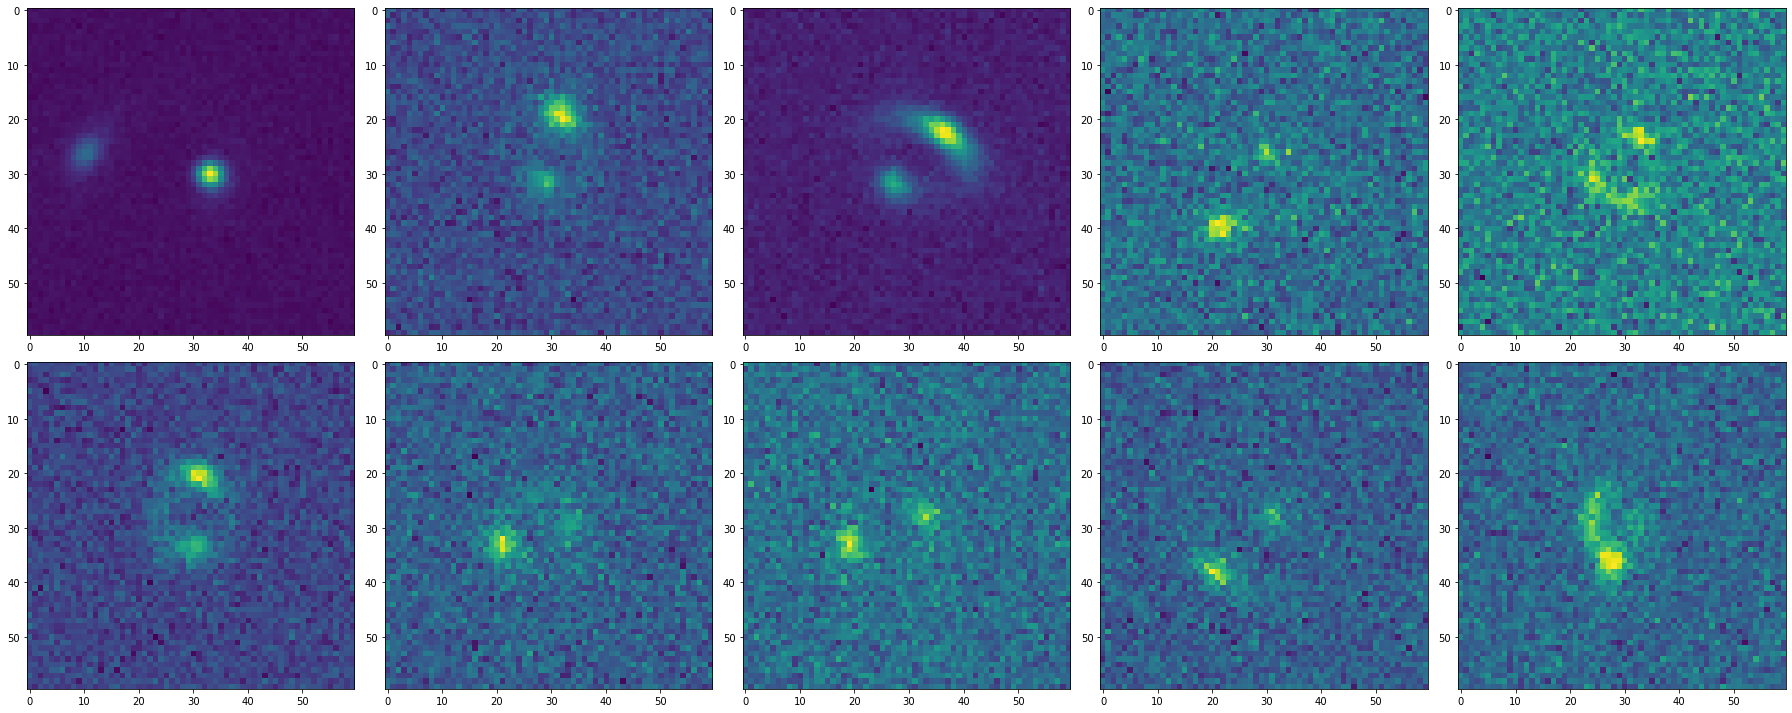

In [79]:
from plot_image_collage import plot_collage
plot_collage(f'/{training_directory}/training/LensPop_Config/',2,5)


In [ ]:
new_config_dict_values = {
             'main_deflector':{
                  'parameters':{
                       'z_lens':0.3,
                       'theta_E':0.1
                  }}}
from functools import reduce  # forward compatibility for Python 3
import operator

def getFromDict(dataDict, mapList):
    return reduce(operator.getitem, mapList, dataDict)

begin_config=False
key_tracker = []
for line in open('/Users/hollowayp/paltas/paltas/Configs/Examples/config_LSST.py','r'):
	if begin_config:
		line_0 = line.replace('\t','').replace('\n','') #Removing junk
		line_3 = line_0.replace("'",'').split(':')[0]
		line_4 = line_0.strip().split(':')[0].replace("'",'')
		if len(line_0.strip())>1:
			if line_0.strip()[0]=='#': continue #Ignoring lines which are commented out
		if '{' in line_0:
			key_tracker.append(line_4)
			print(key_tracker)
		if '}' in line_0:
			key_tracker = key_tracker[:-1]
#			print(key_tracker)
		try:
			#If the update-dictionary contains these keys (and the corresponding value is a float), the 
			#value needs to be updated
			if isinstance(getFromDict(new_config_dict_values,key_tracker+[line_3]),float):
				print('HEREEEE',key_tracker+[line_3],
		  		getFromDict(new_config_dict_values,key_tracker+[line_3]))
			else:
				print('Else',line_0)
		except Exception as ex:
			print('Ex',line_0)
			pass
	if 'config_dict' in line: begin_config=True

print(key_tracker)